<a href="https://colab.research.google.com/github/rororoy/Learning-Machine-Learning/blob/main/SVM_based_on_SMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problem 13 - Implementing the Sequential Minimal Optimization (SMO) algorithm**
**Written by Roy Lavrov - 322492059 - Intro to machine learning class 2025**


## **Intro**
This program implements an SVM learning model using the SMO (Sequential Minimal Optimization) algorithm, as described in the 1998 paper by John C. Platt at Microsoft research on the SMO:

[Sequential Minimal Optimization: A Fast Algorithm for
Training Support Vector Machines, 1998](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr-98-14.pdf)



**Part A:** We start with a generalized implementation of the SMO class - adopting the algorithm and heuristics used in the paper.

**Part B:** We address linear classifiers using SVMs with the SMO we implemented in Part A. We will use the Iris flower data set introduced by Ronald Fisher to train and evaluate the SVM. Both with the linear and then with rbf kernels (as multiclass models).

## **Preperations:**

In [33]:
import numpy as np

# **SMO Algorithm Implementation**

#### **1. Strategy for Picking Multipliers to Optimize**
**First Multiplier Selection (Outer Loop)**
The implementation uses a two-level strategy based on Section 2.2 of Platt's paper:

```
while num_changed > 0 or examine_all:
  if examine_all:
    # Full pass over all training examples
    for i in range(self.N):
      num_changed += self.examine_example(i)
  else:
    # Pass over non-bound examples only
    non_bound_indices = [i for i in range(self.N) if 0 < self.alphas[i] < self.C]
    for i in non_bound_indices:
      num_changed += self.examine_example(i)
```

**Non-bound priority:** Examples with 0 < α < C are on the margin and most likely to change during optimization

**Alternating strategy:** Prevents missing bound examples that become violators after non-bound optimization

**KKT-based selection:** Only examples violating KKT conditions are selected as first multipliers

Our KKT violation check:
```
r2 = E2 * y2  # where E2 = u2 - y2
if (r2 < -self.tol and a2 < self.C) or (r2 > self.tol and a2 > 0):
```
**Under-supported examples:** y*u < 1 - ε but α < C

**Over-supported examples:** y*u > 1 + ε but α > 0

Here we use the epsilon (ε = 0.001) to allow for better tolerance for faster convergence without an endless loop of the program trying to constantly optimize


---


**Second multiplier selection:**

Following the heuristics described in the paper we use a two stage approach:

**Stage 1: Maximum Step Heuristic**

derived from equation (16) from the paper: α₂ᴺᴱᵂ = α₂ᴼᴸᴰ + y₂(E₁ - E₂)/η
```
def second_choice_heuristic(self, i2, E2, non_bound_indices):
  max_step = 0
  i1 = -1
  for i in non_bound_indices:
    if i == i2:
        continue
    E1 = self.error_cache[i]
    step = abs(E1 - E2)
    if step > max_step:
        max_step = step
        i1 = i
  return i1
```

Where the step size is proportional to |E₁ - E₂|

**Level 2: Non-bound Iteration**

If the heuristic fails (e.g., duplicate points), iterate through all non-bound examples starting randomly:
```
random_start = np.random.randint(len(non_bound_indices))
for j in range(len(non_bound_indices)):
  i1 = non_bound_indices[(random_start + j) % len(non_bound_indices)]
```

**Level 3: As the last resort try a full iteration over all data**

Starting off at a random spot to prevent bias


#### **2. Convergence Criterion**

The algorithm converges when no examples violate KKT conditions within tolerance:

```
while num_changed > 0 or examine_all:
  num_changed = 0
  # ... optimization attempts ...
  if examine_all:
```

#### **3. Computing the threshold b**

After every optimization step, b is recomputed, one b for every multiplier

```
# Compute b1 valid when α₁ is non-bound
b1 = E1 + y1 * (a1_new - a1_old) * k11 + y2 * (a2_new - a2_old) * k12 + self.b

# Compute b2 valid when α₂ is non-bound  
b2 = E2 + y1 * (a1_new - a1_old) * k12 + y2 * (a2_new - a2_old) * k22 + self.b

# Decision logic
if 0 < a1_new < self.C:
    self.b = b1  # Use b1 if α₁ is non-bound
elif 0 < a2_new < self.C:
    self.b = b2  # Use b2 if α₂ is non-bound
else:
    self.b = (b1 + b2) / 2  # Average if both are bound
```

## **The SMO Class**

Now we get to our SMO class that implements the algorithm

Our choice of parameters and hyper-parameters:


*   **C** - the regularization parameter intialied to 1 by default (and what we end up using to train the model)
*   **ε** - set to 0.001 as suggested in the paper
*   **max_iter** - set as a default to 1000, as I have encountered a problem of the program trying endlessly to optimize all the multipliers causing the program to nvever terminate (even by following the algorithm in the paper with the suggested ε value)
*   **gamma** - used later on for the **rbf** kernel

For this part, I have used those parameters to stay true to the paper, cross-validation and evaluation sets will be later used to pick the hyper-parameters



In [35]:
class SMO:
  def __init__(self, C=1.0, tol=1e-3, kernel_type='linear', gamma=0.1, max_iter=1000):
    """
    SMO Algorithm Implementation

    Parameters:
    -----------
    C : float
        Regularization parameter
    tol : float
        Tolerance for KKT conditions (epsilon in paper)
    kernel_type : str
        'linear' or 'rbf'
    gamma : float
        Parameter for RBF kernel
    max_iter : int
        Maximum number of iterations (prevents infinite loops)
    """
    self.C = C
    self.tol = tol
    self.kernel_type = kernel_type
    self.gamma = gamma
    self.max_iter = max_iter

  def kernel(self, x1, x2):
    """Compute kernel function K(x1, x2)"""
    if self.kernel_type == 'linear':
        return np.dot(x1, x2)
    elif self.kernel_type == 'rbf':
        diff = x1 - x2
        return np.exp(-self.gamma * np.dot(diff, diff))
    else:
        raise ValueError("Unknown kernel type")

  def compute_output(self, i):
    """Compute SVM output u_i = Σ(α_j * y_j * K(x_j, x_i)) - b"""
    u = -self.b
    for j in range(self.N):
      if self.alphas[j] > 0:
        u += self.alphas[j] * self.Y[j] * self.kernel(self.X[j], self.X[i])
    return u

  def compute_error(self, i):
    """Compute error E_i = u_i - y_i"""
    return self.compute_output(i) - self.Y[i]

  def get_bounds(self, i1, i2):
    """Compute L and H bounds for alpha2"""
    y1, y2 = self.Y[i1], self.Y[i2]
    a1, a2 = self.alphas[i1], self.alphas[i2]

    if y1 != y2:
      L = max(0, a2 - a1)
      H = min(self.C, self.C + a2 - a1)
    else:
      L = max(0, a2 + a1 - self.C)
      H = min(self.C, a2 + a1)

    return L, H

  def take_step(self, i1, i2):
    """Optimize two Lagrange multipliers"""
    if i1 == i2:
      return False

    a1_old = self.alphas[i1]
    a2_old = self.alphas[i2]
    y1 = self.Y[i1]
    y2 = self.Y[i2]

    if 0 < a1_old < self.C:
      E1 = self.error_cache[i1]
    else:
      E1 = self.compute_error(i1)

    if 0 < a2_old < self.C:
      E2 = self.error_cache[i2]
    else:
      E2 = self.compute_error(i2)

    s = y1 * y2

    L, H = self.get_bounds(i1, i2)
    if L == H:
      return False

    k11 = self.kernel(self.X[i1], self.X[i1])
    k12 = self.kernel(self.X[i1], self.X[i2])
    k22 = self.kernel(self.X[i2], self.X[i2])
    eta = k11 + k22 - 2 * k12

    if eta > 0:
      a2_new = a2_old + y2 * (E1 - E2) / eta
      if a2_new < L:
        a2_new = L
      elif a2_new > H:
        a2_new = H
    else:
      Lobj = self.objective_at_bounds(i1, i2, L, a1_old, a2_old)
      Hobj = self.objective_at_bounds(i1, i2, H, a1_old, a2_old)

      if Lobj < Hobj - self.tol:
        a2_new = L
      elif Lobj > Hobj + self.tol:
        a2_new = H
      else:
        a2_new = a2_old

    # Use a slightly more relaxed tolerance for convergence
    if abs(a2_new - a2_old) < self.tol * (a2_new + a2_old + self.tol):
      return False

    a1_new = a1_old + s * (a2_old - a2_new)

    # Ensure alphas stay within bounds due to numerical issues
    a1_new = max(0, min(self.C, a1_new))
    a2_new = max(0, min(self.C, a2_new))

    b1 = E1 + y1 * (a1_new - a1_old) * k11 + y2 * (a2_new - a2_old) * k12 + self.b
    b2 = E2 + y1 * (a1_new - a1_old) * k12 + y2 * (a2_new - a2_old) * k22 + self.b

    if 0 < a1_new < self.C:
      self.b = b1
    elif 0 < a2_new < self.C:
      self.b = b2
    else:
      self.b = (b1 + b2) / 2

    self.alphas[i1] = a1_new
    self.alphas[i2] = a2_new

    for i in range(self.N):
      if 0 < self.alphas[i] < self.C:
        if i == i1 or i == i2:
          self.error_cache[i] = 0
        else:
          self.error_cache[i] += y1 * (a1_new - a1_old) * self.kernel(self.X[i1], self.X[i]) + \
                                y2 * (a2_new - a2_old) * self.kernel(self.X[i2], self.X[i]) + \
                                self.b - b1

    return True

  def examine_example(self, i2):
    """Check if example violates KKT and try to optimize"""
    y2 = self.Y[i2]
    a2 = self.alphas[i2]

    if 0 < a2 < self.C:
      E2 = self.error_cache[i2]
    else:
      E2 = self.compute_error(i2)

    r2 = E2 * y2

    if (r2 < -self.tol and a2 < self.C) or (r2 > self.tol and a2 > 0):
      non_bound_indices = [i for i in range(self.N) if 0 < self.alphas[i] < self.C]

      if len(non_bound_indices) > 1:
        i1 = self.second_choice_heuristic(i2, E2, non_bound_indices)
        if i1 != -1 and self.take_step(i1, i2):
          return True

        random_start = np.random.randint(len(non_bound_indices))
        for j in range(len(non_bound_indices)):
          i1 = non_bound_indices[(random_start + j) % len(non_bound_indices)]
          if self.take_step(i1, i2):
            return True

      random_start = np.random.randint(self.N)
      for j in range(self.N):
        i1 = (random_start + j) % self.N
        if self.take_step(i1, i2):
          return True

    return False

  def second_choice_heuristic(self, i2, E2, non_bound_indices):
    """Choose i1 to maximize step size |E1 - E2|"""
    max_step = 0
    i1 = -1

    for i in non_bound_indices:
      if i == i2:
          continue
      E1 = self.error_cache[i]
      step = abs(E1 - E2)
      if step > max_step:
        max_step = step
        i1 = i

    return i1

  def objective_at_bounds(self, i1, i2, a2_new, a1_old, a2_old):
    """Compute objective function value when a2 = a2_new"""
    y1, y2 = self.Y[i1], self.Y[i2]
    s = y1 * y2
    a1_new = a1_old + s * (a2_old - a2_new)

    L1 = a1_new - 0.5 * self.kernel(self.X[i1], self.X[i1]) * a1_new**2
    L2 = a2_new - 0.5 * self.kernel(self.X[i2], self.X[i2]) * a2_new**2
    L12 = s * self.kernel(self.X[i1], self.X[i2]) * a1_new * a2_new

    return -(L1 + L2 - L12)

  def fit(self, X, Y):
    """Train SVM using SMO algorithm with iteration limit"""
    self.X = X
    self.Y = Y
    self.N = len(Y)

    self.alphas = np.zeros(self.N)
    self.b = 0.0
    self.error_cache = -Y.copy()

    num_changed = 0
    examine_all = True
    iter_count = 0

    while (num_changed > 0 or examine_all) and iter_count < self.max_iter:
      num_changed = 0

      if examine_all:
        for i in range(self.N):
            num_changed += self.examine_example(i)
      else:
        non_bound_indices = [i for i in range(self.N) if 0 < self.alphas[i] < self.C]
        for i in non_bound_indices:
          num_changed += self.examine_example(i)

      if examine_all:
        examine_all = False
      elif num_changed == 0:
        examine_all = True

      iter_count += 1

      # Print progress every 100 iterations
      if iter_count % 100 == 0:
        print(f"    Iteration {iter_count}: {num_changed} changes")

    if iter_count >= self.max_iter:
      print(f"    Warning: Reached maximum iterations ({self.max_iter})")
    else:
      print(f"    Converged in {iter_count} iterations")

    self.support_indices = np.where(self.alphas > 0)[0]
    self.support_vectors = X[self.support_indices]
    self.support_alphas = self.alphas[self.support_indices]
    self.support_labels = Y[self.support_indices]

  def predict(self, X_test):
    """Predict labels for test data"""
    N_test = len(X_test)
    predictions = np.zeros(N_test)

    for i in range(N_test):
      u = -self.b
      for j, sv_idx in enumerate(self.support_indices):
          u += self.support_alphas[j] * self.support_labels[j] * \
                self.kernel(self.support_vectors[j], X_test[i])
      predictions[i] = np.sign(u)

    return predictions



---



## Running the code


We will run our SMO class with the linear kernel:

we use a synthetic data set of simple points on a graph with some noise in the linearly seperable case.


In [36]:
# Generate synthetic linearly separable data
np.random.seed(42)

# Positive examples
pos_mean = [2, 2]
pos_cov = [[0.5, 0.1], [0.1, 0.5]]
X_pos = np.random.multivariate_normal(pos_mean, pos_cov, 50)

# Negative examples
neg_mean = [-2, -2]
neg_cov = [[0.5, -0.1], [-0.1, 0.5]]
X_neg = np.random.multivariate_normal(neg_mean, neg_cov, 50)

# Combine data
X = np.vstack([X_pos, X_neg])
Y = np.hstack([np.ones(50), -np.ones(50)])

# Shuffle data
shuffle_idx = np.random.permutation(100)
X = X[shuffle_idx]
Y = Y[shuffle_idx]

**Now to train and test our SVM:**

We create the SVM class by selecting the kernel type to linear and a starting value of C (=regularization) as 1

In [37]:
# Train linear SVM
print("Training Linear SVM...")
svm_linear = SMO(C=1.0, kernel_type='linear')
svm_linear.fit(X, Y)

# Test predictions
predictions_linear = svm_linear.predict(X[:10])

print(f"\nLinear SVM predictions on first 10 examples: {predictions_linear}")
print(f"True labels: {Y[:10]}")
print(f"Accuracy: {np.mean(predictions_linear == Y[:10]):.2f}")

Training Linear SVM...
    Iteration 100: 2 changes
    Iteration 200: 2 changes
    Converged in 255 iterations

Linear SVM predictions on first 10 examples: [-1.  1. -1.  1. -1.  1. -1. -1.  1.  1.]
True labels: [-1.  1. -1.  1. -1.  1. -1. -1.  1.  1.]
Accuracy: 1.00


Looking at the perfect accuracy - the model performed well in this controled enviorment of a pretty simple data set of easy to seperate set of points already converging around two centers

The model will get stress-tested in the next part on "real-life" data from a dataset.


---



---



# **Implementing a multi class SVM with the SMO alogrithm**

As described above in the intro we will now use the implemintation of the class to make a multi class (one vs all) model on the Iris flower data set of 3 different species (so 3 seperate SMO models)

Starting off with models using the linear kernel

Four features were measured from each sample over three classes:


*   Sepal length
*   Sepal width
*   Petal length
*   Petal width



## **Preperations:**

In [39]:
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np

iris = datasets.load_iris()

## **A scatterplot of the data set based on the four features for each class**

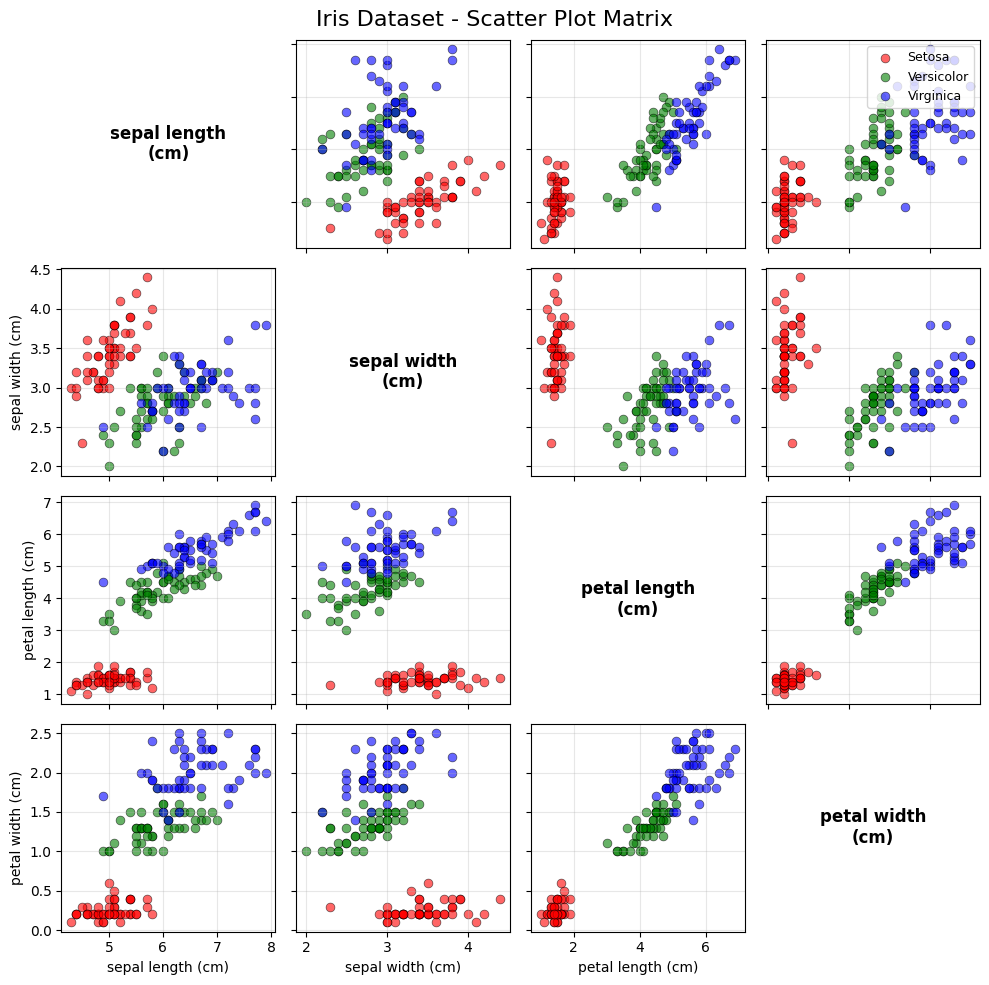

In [40]:
# Load the iris dataset
X = iris.data
y = iris.target
feature_names = iris.feature_names
target_names = iris.target_names

# Define colors for each class
colors = ['red', 'green', 'blue']
class_names = ['Setosa', 'Versicolor', 'Virginica']

# Create a 4x4 subplot grid with smaller figure size
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle('Iris Dataset - Scatter Plot Matrix', fontsize=16, y=0.98)

# Iterate through all subplot positions
for i in range(4):
  for j in range(4):
    ax = axes[i, j]

    if i == j:
      # Diagonal: Leave empty and just show feature name
      ax.text(0.5, 0.5, feature_names[i].replace(' (cm)', '\n(cm)'),
              ha='center', va='center', fontsize=12,
              transform=ax.transAxes, weight='bold')
      ax.set_xticks([])
      ax.set_yticks([])
      ax.spines['top'].set_visible(False)
      ax.spines['right'].set_visible(False)
      ax.spines['bottom'].set_visible(False)
      ax.spines['left'].set_visible(False)
    else:
      # Off-diagonal: Create scatter plot
      for class_idx, (color, name) in enumerate(zip(colors, class_names)):
        mask = y == class_idx
        ax.scatter(X[mask, j], X[mask, i],
                  c=color, label=name, alpha=0.6,
                  edgecolors='black', linewidth=0.5, s=40)

      # Add grid
      ax.grid(True, alpha=0.3)

      # Set labels only on edges
      if i == 3:  # Bottom row
        ax.set_xlabel(feature_names[j], fontsize=10)
      else:
        ax.set_xticklabels([])

      if j == 0:  # Left column
        ax.set_ylabel(feature_names[i], fontsize=10)
      else:
        ax.set_yticklabels([])

      # Add legend only to one subplot
      if i == 0 and j == 3:
        ax.legend(loc='upper right', fontsize=9)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

**Analyzing the scatterplot we notice that Iris Setosa seems to be the class mose easily seperable to the point where a line could be drawn without soft margins and still seperate the data perfectly**

**However we should expect the middle class (versicolor) to be the toughest to seperate at a decent accuracy prediction score - seing as a straight line would be hard to draw for every manipulation of the features**


---



## **Training and analyzing three individually trained SMO models in a one vs all method (linear kernel)**
**For this stage we will train all 3 models on our data with a train-validation-test split (with the heuristics of train (60%), validation (20%), and test (20%)).**

We will use the different sets to choose the best performing C hyper-parameter for each class and **compile a report and summary below**

The below code:


1.   Splits the data into the different sets
2.   Prepares the data to function as a one vs all problem
3.   Defines different C parameters to tune the models to using the tuning function, and track the performance of the different models (accuracy) as we tune
4.   Compile the history and data from the tuning process into visualized graphs of the results and best perfomring parameters




Splitting data into train/val/test...
Dataset size: 150
Training set size: 90 (60%)
Validation set size: 30 (20%)
Test set size: 30 (20%)

TRAINING BINARY SVMs WITH C TUNING (LINEAR kernel)

Binary SVM: setosa (class 0) vs rest

Class distribution:
  Positive: 30 samples
  Negative: 60 samples

Tuning C parameter...
  Testing C = 0.10...     Converged in 13 iterations
Accuracy: 1.000, Time: 0.0s, SVs: 18
  Testing C = 0.50...     Converged in 6 iterations
Accuracy: 1.000, Time: 0.0s, SVs: 7
  Testing C = 1.00...     Converged in 8 iterations
Accuracy: 1.000, Time: 0.0s, SVs: 8
  Testing C = 5.00...     Converged in 10 iterations
Accuracy: 1.000, Time: 0.0s, SVs: 15
  Testing C = 10.00...     Converged in 6 iterations
Accuracy: 1.000, Time: 0.0s, SVs: 7

Best C = 0.1 (val acc: 1.000)

Training with best C...
    Converged in 14 iterations
Done in 0.1s

Results:
  Test Accuracy: 1.000
  Support Vectors: 9
  - Bound (α = C): 2
  - Non-bound (0 < α < C): 7

Binary SVM: versicolor (class 1

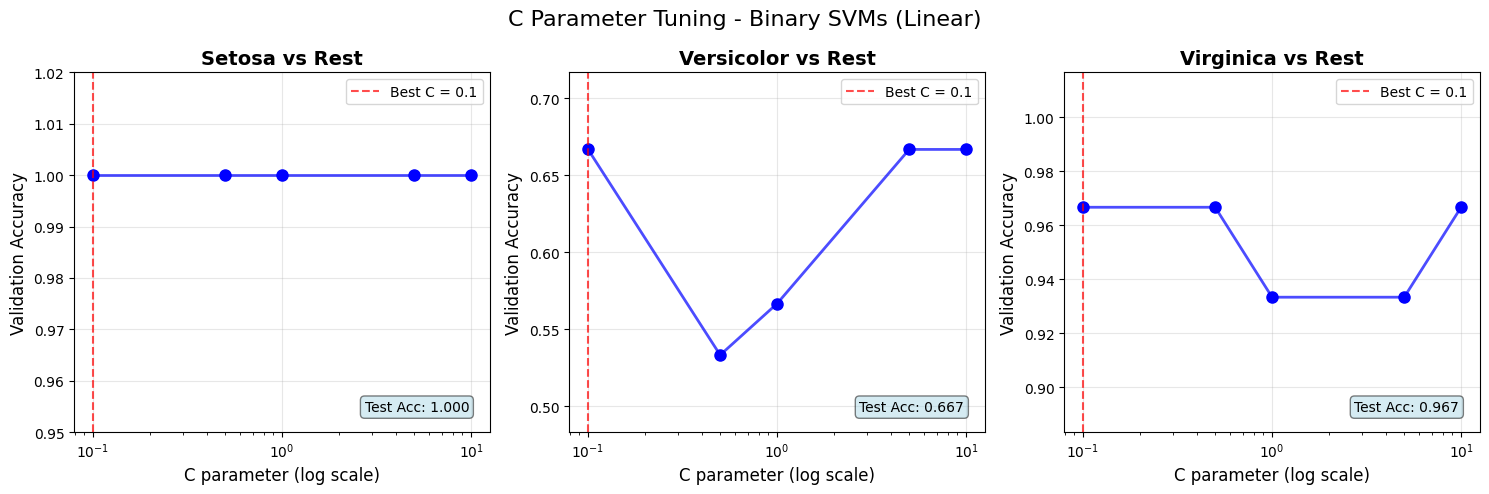


SUMMARY (LINEAR kernel)

Results:

       Class |   Best C |  Test Acc |             SVs
------------------------------------------------------------
      setosa |     0.10 |     1.000 |               9
  versicolor |     0.10 |     0.667 |              73
   virginica |     0.10 |     0.967 |              39


In [41]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time

# Split data - 60% train, 20% val, 20% test
print("\nSplitting data into train/val/test...")

# 80/20 split first
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Split remaining 80% into 75/25 (gives us 60/20 overall)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print(f"Dataset size: {len(X)}")
print(f"Training set size: {len(X_train)} ({100*len(X_train)/len(X):.0f}%)")
print(f"Validation set size: {len(X_val)} ({100*len(X_val)/len(X):.0f}%)")
print(f"Test set size: {len(X_test)} ({100*len(X_test)/len(X):.0f}%)")

# Helper functions
def create_binary_labels(y_multi, class_idx):
    """Convert to binary labels for OvR"""
    return np.where(y_multi == class_idx, 1, -1)

def tune_C_parameter(X_train, y_train, X_val, y_val, C_candidates, kernel, gamma, SMO):
    """
    Find best C using validation set
    """
    validation_results = []
    best_C = None
    best_val_accuracy = -1

    for C in C_candidates:
        print(f"  Testing C = {C:.2f}...", end=' ')
        start_time = time.time()

        # Train with current C
        # Create SVM with gamma parameter for RBF kernel
        if kernel == 'rbf':
            svm = SMO(C=C, kernel_type=kernel, gamma=gamma, tol=1e-2, max_iter=500)
        else:
            svm = SMO(C=C, kernel_type=kernel, tol=1e-2, max_iter=500)

        try:
            svm.fit(X_train, y_train)

            # Validate
            val_predictions = svm.predict(X_val)
            val_accuracy = np.mean(val_predictions == y_val)

            elapsed = time.time() - start_time
            print(f"Accuracy: {val_accuracy:.3f}, Time: {elapsed:.1f}s, SVs: {len(svm.support_indices)}")

            validation_results.append({
                'C': C,
                'val_accuracy': val_accuracy,
                'n_support_vectors': len(svm.support_indices),
                'n_bound_sv': np.sum(svm.alphas == C),
                'n_non_bound_sv': np.sum((svm.alphas > 0) & (svm.alphas < C))
            })

            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                best_C = C

        except Exception as e:
            print(f"Failed: {str(e)}")
            validation_results.append({
                'C': C,
                'val_accuracy': 0,
                'n_support_vectors': 0,
                'n_bound_sv': 0,
                'n_non_bound_sv': 0
            })

    return best_C, validation_results


def train_multiple_svms_with_kernel(X_train, y_train, X_val, y_val, X_test, y_test,
                                   target_names, kernel='linear', C_candidates=None, gamma=0.1, SMO=None):
    """
    Train multiple SVMs with specified kernel using pre-split data

    Parameters:
    -----------
    X_train, y_train : Training data
    X_val, y_val : Validation data
    X_test, y_test : Test data
    target_names : list
        Names of target classes
    kernel : str
        Kernel type ('linear' or 'rbf')
    C_candidates : list
        C values to test (default: [0.1, 0.5, 1.0, 5.0, 10.0])
    gamma : float
        Gamma parameter for RBF kernel (default: 0.1)
    SMO : class
        SMO class for SVM training

    Returns:
    --------
    all_results : dict
        Results for each class
    trained_svms : list
        List of trained SVM models
    """

    if C_candidates is None:
        C_candidates = [0.1, 0.5, 1.0, 5.0, 10.0]

    if SMO is None:
        raise ValueError("SMO class must be provided")

    # Train binary SVMs
    print("\n" + "="*70)
    print(f"TRAINING BINARY SVMs WITH C TUNING ({kernel.upper()} kernel)")
    if kernel == 'rbf':
        print(f"Using gamma = {gamma}")
    print("="*70)

    all_results = {}
    trained_svms = []

    for class_idx in range(3):
        class_name = target_names[class_idx]
        print(f"\n{'='*50}")
        print(f"Binary SVM: {class_name} (class {class_idx}) vs rest")
        print(f"{'='*50}")

        # Binary labels
        y_train_binary = create_binary_labels(y_train, class_idx)
        y_val_binary = create_binary_labels(y_val, class_idx)
        y_test_binary = create_binary_labels(y_test, class_idx)

        print(f"\nClass distribution:")
        print(f"  Positive: {np.sum(y_train_binary == 1)} samples")
        print(f"  Negative: {np.sum(y_train_binary == -1)} samples")

        # Find best C
        print(f"\nTuning C parameter...")
        best_C, val_results = tune_C_parameter(
            X_train, y_train_binary, X_val, y_val_binary, C_candidates, kernel, gamma, SMO
        )

        if best_C is None:
            print("ERROR: Training failed")
            continue

        print(f"\nBest C = {best_C} (val acc: {max([r['val_accuracy'] for r in val_results]):.3f})")

        # Train final model
        print(f"\nTraining with best C...")
        if kernel == 'rbf':
            final_svm = SMO(C=best_C, kernel_type=kernel, gamma=gamma, tol=1e-2, max_iter=1000)
        else:
            final_svm = SMO(C=best_C, kernel_type=kernel, tol=1e-2, max_iter=1000)

        start_time = time.time()
        final_svm.fit(X_train, y_train_binary)
        elapsed = time.time() - start_time

        print(f"Done in {elapsed:.1f}s")

        # Test performance
        test_predictions = final_svm.predict(X_test)
        test_accuracy = np.mean(test_predictions == y_test_binary)

        print(f"\nResults:")
        print(f"  Test Accuracy: {test_accuracy:.3f}")
        print(f"  Support Vectors: {len(final_svm.support_indices)}")
        print(f"  - Bound (α = C): {np.sum(final_svm.alphas == best_C)}")
        print(f"  - Non-bound (0 < α < C): {np.sum((final_svm.alphas > 0) & (final_svm.alphas < best_C))}")

        trained_svms.append(final_svm)
        all_results[class_name] = {
            'best_C': best_C,
            'validation_results': val_results,
            'test_accuracy': test_accuracy,
            'svm': final_svm
        }

    # Plot C tuning results
    if len(all_results) > 0:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        for idx, (class_name, results) in enumerate(all_results.items()):
            ax = axes[idx] if len(all_results) == 3 else axes

            # Get data
            C_values = [r['C'] for r in results['validation_results']]
            val_accuracies = [r['val_accuracy'] for r in results['validation_results']]

            # Sort by C for proper line plot
            sorted_pairs = sorted(zip(C_values, val_accuracies), key=lambda x: x[0])
            C_values_sorted = [pair[0] for pair in sorted_pairs]
            val_accuracies_sorted = [pair[1] for pair in sorted_pairs]

            # Remove failed runs
            valid_points = [(c, acc) for c, acc in zip(C_values_sorted, val_accuracies_sorted) if acc > 0]

            if valid_points:
                C_values_clean = [point[0] for point in valid_points]
                val_accuracies_clean = [point[1] for point in valid_points]

                # Plot line and points
                ax.plot(C_values_clean, val_accuracies_clean, 'b-', linewidth=2, alpha=0.7)
                ax.plot(C_values_clean, val_accuracies_clean, 'bo', markersize=8)

                ax.set_xscale('log')

            # Mark best C
            ax.axvline(x=results['best_C'], color='red', linestyle='--', alpha=0.7,
                      label=f'Best C = {results["best_C"]}')

            ax.set_xlabel('C parameter (log scale)', fontsize=12)
            ax.set_ylabel('Validation Accuracy', fontsize=12)
            ax.set_title(f'{class_name.capitalize()} vs Rest', fontsize=14, fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.legend()

            # y-axis limits
            if valid_points:
                min_acc = min(val_accuracies_clean)
                max_acc = max(val_accuracies_clean)
                y_margin = 0.05
                ax.set_ylim([max(0, min_acc - y_margin), min(1.02, max_acc + y_margin)])
            else:
                ax.set_ylim([0.8, 1.02])

            # Add test accuracy
            ax.text(0.95, 0.05, f'Test Acc: {results["test_accuracy"]:.3f}',
                    transform=ax.transAxes, ha='right', va='bottom',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.5))

        plt.suptitle(f'C Parameter Tuning - Binary SVMs ({kernel.capitalize()})', fontsize=16)
        plt.tight_layout()
        plt.show()

    # Summary
    print("\n" + "="*70)
    print(f"SUMMARY ({kernel.upper()} kernel)")
    print("="*70)

    print(f"\nResults:")
    print(f"\n{'Class':>12} | {'Best C':>8} | {'Test Acc':>9} | {'SVs':>15}")
    print("-" * 60)

    for class_name, results in all_results.items():
        print(f"{class_name:>12} | {results['best_C']:>8.2f} | "
              f"{results['test_accuracy']:>9.3f} | "
              f"{len(results['svm'].support_indices):>15}")

    return all_results, trained_svms


# Linear kernel training
kernel = 'linear'
linear_results, linear_svms = train_multiple_svms_with_kernel(
    X_train, y_train, X_val, y_val, X_test, y_test,
    target_names, kernel=kernel, SMO=SMO
)



---


### **Analyzing the results above**
**We trained and evaluated each class the was individualy trained to linearly seperate it from the rest**

Its clear that for some clases a linear kernel wouldn't suffice since for 2 of the 3 classes - the problem isn't linearly seperable, this explained the poor accuracy performance for 2 of the classes

For the next part we will use the best C value for each class to compile all individually trained one vs all models into one multiclass model and provide the confusion matrix and scores for each class

We will compile the confidence scores from each model and using **argmax** decide on the correct classification:


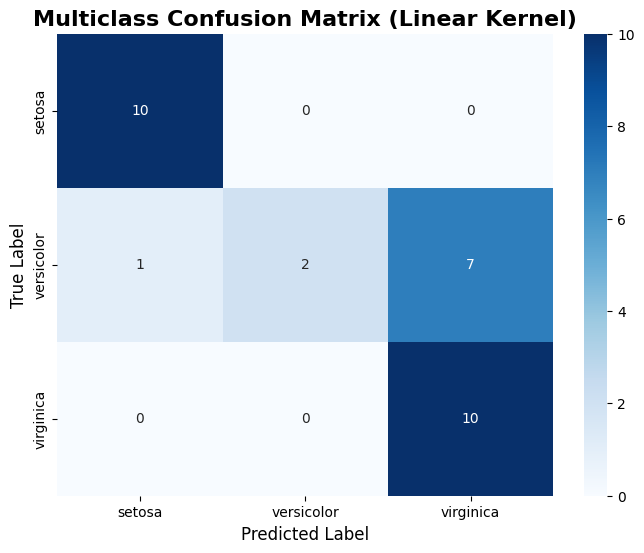


Overall Multiclass Accuracy (Linear kernel): 0.733

Per-class Performance:
       Class |  Precision |     Recall |   F1-Score
--------------------------------------------------
      setosa |      0.909 |      1.000 |      0.952
  versicolor |      1.000 |      0.200 |      0.333
   virginica |      0.588 |      1.000 |      0.741


In [42]:
# Combine three binary SVMs into multiclass classifier
def predict_multiclass(X, trained_svms):
    """
    Use decision function scores to predict multiclass labels
    """
    n_samples = X.shape[0]
    n_classes = len(trained_svms)

    # Get decision scores from each binary classifier
    scores = np.zeros((n_samples, n_classes))

    for i, svm in enumerate(trained_svms):
        # Compute decision values for each sample
        for j in range(n_samples):
            u = -svm.b
            for k, sv_idx in enumerate(svm.support_indices):
                u += svm.support_alphas[k] * svm.support_labels[k] * \
                     svm.kernel(svm.support_vectors[k], X[j])
            scores[j, i] = u

    # Predict class with highest score
    predictions = np.argmax(scores, axis=1)

    return predictions, scores


def evaluate_multiclass_svm(X_test, y_test, trained_svms, target_names, kernel_name=''):
    """
    Evaluate multiclass SVM performance and plot confusion matrix

    Parameters:
    -----------
    X_test : array-like
        Test features
    y_test : array-like
        True test labels
    trained_svms : list
        List of trained binary SVM models
    target_names : list
        Names of target classes
    kernel_name : str
        Name of kernel for display purposes (e.g., 'Linear', 'RBF')

    Returns:
    --------
    results : dict
        Dictionary containing predictions, scores, confusion matrix, and accuracy
    """

    # Get multiclass predictions
    y_pred_multi, decision_scores = predict_multiclass(X_test, trained_svms)

    # Calculate multiclass confusion matrix
    cm_multi = confusion_matrix(y_test, y_pred_multi)

    # Plot main confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)

    title = 'Multiclass Confusion Matrix'
    if kernel_name:
        title += f' ({kernel_name} Kernel)'

    plt.title(title, fontsize=16, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.show()

    # Calculate overall accuracy
    overall_accuracy = accuracy_score(y_test, y_pred_multi)

    print(f"\nOverall Multiclass Accuracy", end='')
    if kernel_name:
        print(f" ({kernel_name} kernel)", end='')
    print(f": {overall_accuracy:.3f}")

    # Calculate per-class metrics
    print(f"\nPer-class Performance:")
    print(f"{'Class':>12} | {'Precision':>10} | {'Recall':>10} | {'F1-Score':>10}")
    print("-" * 50)

    for i, class_name in enumerate(target_names):
        # True positives, false positives, false negatives
        tp = cm_multi[i, i]
        fp = cm_multi[:, i].sum() - tp
        fn = cm_multi[i, :].sum() - tp

        # Calculate metrics
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        print(f"{class_name:>12} | {precision:>10.3f} | {recall:>10.3f} | {f1:>10.3f}")

    # Store results
    results = {
        'predictions': y_pred_multi,
        'decision_scores': decision_scores,
        'confusion_matrix': cm_multi,
        'overall_accuracy': overall_accuracy,
        'kernel': kernel_name
    }

    return results


# Usage for linear kernel (using the results from previous training):
linear_evaluation = evaluate_multiclass_svm(
    X_test, y_test, linear_svms, target_names, kernel_name='Linear'
)

### **Results analysis of the multiclass SVM**
Looking at the total accuracy for the multiclass problem we notice a few things:
1.   **The model best performs for the Setose and Virginica classes -** Not really surprising considering the fact that from the scaterplot we generated really early the Versicolor class we noticed it was going to be really hard to linearly seperate that class from the rest because the data always lies between the 2 different classes for each combination of features. No single line could be drawn to seperate perfectly that class from the rest.
2.   **Perfect results for the rest** - This is exactly for the above reason because they are easy to seperate with a single line devide.

**If a conclusion is to be drawn - the linear kernel does not suffice for the multiclass problem**



---

**Now a per-class analysis of confusion matrix and sensitivity scores**

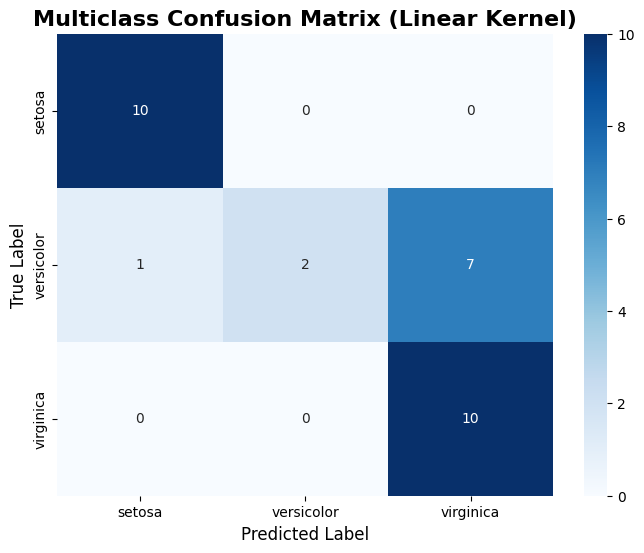


Overall Multiclass Accuracy (Linear kernel): 0.733

Per-class Performance:
       Class |  Precision |     Recall |   F1-Score
--------------------------------------------------
      setosa |      0.909 |      1.000 |      0.952
  versicolor |      1.000 |      0.200 |      0.333
   virginica |      0.588 |      1.000 |      0.741

Per-Class Performance (Linear kernel):
       Class |  Accuracy | Sensitivity | Specificity
------------------------------------------------------------
      setosa |     0.967 |       1.000 |       0.950
  versicolor |     0.733 |       0.200 |       1.000
   virginica |     0.767 |       1.000 |       0.650


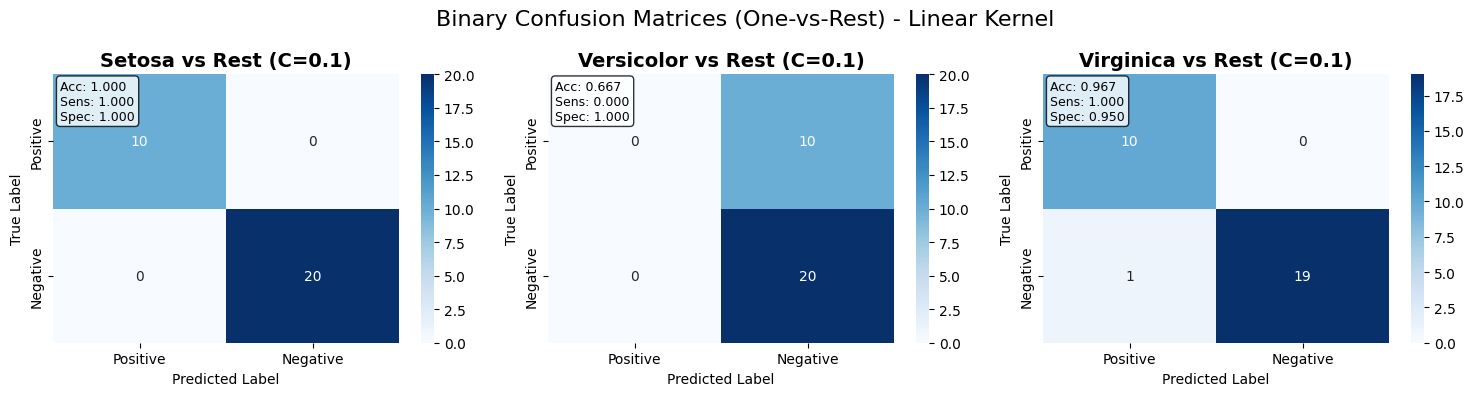

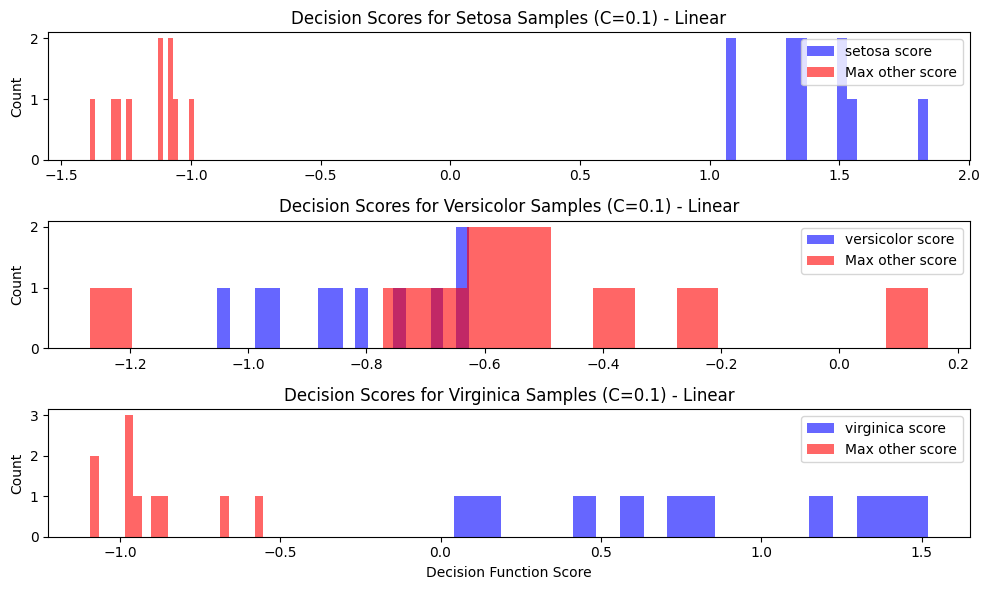

In [43]:
# Combine three binary SVMs into multiclass classifier
def predict_multiclass(X, trained_svms):
    """
    Use decision function scores to predict multiclass labels
    """
    n_samples = X.shape[0]
    n_classes = len(trained_svms)

    # Get decision scores from each binary classifier
    scores = np.zeros((n_samples, n_classes))

    for i, svm in enumerate(trained_svms):
        # Compute decision values for each sample
        for j in range(n_samples):
            u = -svm.b
            for k, sv_idx in enumerate(svm.support_indices):
                u += svm.support_alphas[k] * svm.support_labels[k] * \
                     svm.kernel(svm.support_vectors[k], X[j])
            scores[j, i] = u

    # Predict class with highest score
    predictions = np.argmax(scores, axis=1)

    return predictions, scores


def evaluate_multiclass_svm(X_test, y_test, trained_svms, target_names, kernel_name=''):
    """
    Evaluate multiclass SVM performance and plot confusion matrix

    Parameters:
    -----------
    X_test : array-like
        Test features
    y_test : array-like
        True test labels
    trained_svms : list
        List of trained binary SVM models
    target_names : list
        Names of target classes
    kernel_name : str
        Name of kernel for display purposes (e.g., 'Linear', 'RBF')

    Returns:
    --------
    results : dict
        Dictionary containing predictions, scores, confusion matrix, and accuracy
    """

    # Get multiclass predictions
    y_pred_multi, decision_scores = predict_multiclass(X_test, trained_svms)

    # Calculate multiclass confusion matrix
    cm_multi = confusion_matrix(y_test, y_pred_multi)

    # Plot main confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)

    title = 'Multiclass Confusion Matrix'
    if kernel_name:
        title += f' ({kernel_name} Kernel)'

    plt.title(title, fontsize=16, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.show()

    # Calculate overall accuracy
    overall_accuracy = accuracy_score(y_test, y_pred_multi)

    print(f"\nOverall Multiclass Accuracy", end='')
    if kernel_name:
        print(f" ({kernel_name} kernel)", end='')
    print(f": {overall_accuracy:.3f}")

    # Calculate per-class metrics
    print(f"\nPer-class Performance:")
    print(f"{'Class':>12} | {'Precision':>10} | {'Recall':>10} | {'F1-Score':>10}")
    print("-" * 50)

    for i, class_name in enumerate(target_names):
        # True positives, false positives, false negatives
        tp = cm_multi[i, i]
        fp = cm_multi[:, i].sum() - tp
        fn = cm_multi[i, :].sum() - tp

        # Calculate metrics
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        print(f"{class_name:>12} | {precision:>10.3f} | {recall:>10.3f} | {f1:>10.3f}")

    # Store results
    results = {
        'predictions': y_pred_multi,
        'decision_scores': decision_scores,
        'confusion_matrix': cm_multi,
        'overall_accuracy': overall_accuracy,
        'kernel': kernel_name
    }

    return results


def detailed_svm_analysis(X_test, y_test, trained_svms, target_names, all_results, kernel_name=''):
    """
    Perform detailed analysis of SVM performance including per-class metrics,
    binary confusion matrices, and decision score distributions

    Parameters:
    -----------
    X_test : array-like
        Test features
    y_test : array-like
        True test labels
    trained_svms : list
        List of trained binary SVM models
    target_names : list
        Names of target classes
    all_results : dict
        Results dictionary from training containing best_C values
    kernel_name : str
        Name of kernel for display purposes
    """

    # Get multiclass predictions first
    y_pred_multi, decision_scores = predict_multiclass(X_test, trained_svms)
    cm_multi = confusion_matrix(y_test, y_pred_multi)

    # Per-class metrics
    print(f"\nPer-Class Performance ({kernel_name} kernel):" if kernel_name else "\nPer-Class Performance:")
    print(f"{'Class':>12} | {'Accuracy':>9} | {'Sensitivity':>11} | {'Specificity':>11}")
    print("-" * 60)

    for i, class_name in enumerate(target_names):
        # True positives, false negatives, etc.
        tp = cm_multi[i, i]
        fn = cm_multi[i, :].sum() - tp
        fp = cm_multi[:, i].sum() - tp
        tn = cm_multi.sum() - tp - fn - fp

        # Metrics
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        accuracy = (tp + tn) / cm_multi.sum()

        print(f"{class_name:>12} | {accuracy:>9.3f} | {sensitivity:>11.3f} | {specificity:>11.3f}")

    # Binary confusion matrices for each classifier
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    for idx, (class_name, svm) in enumerate(zip(target_names, trained_svms)):
        # Binary predictions
        y_test_binary = create_binary_labels(y_test, idx)
        y_pred_binary = svm.predict(X_test)

        # Binary confusion matrix
        cm_binary = confusion_matrix(y_test_binary, y_pred_binary, labels=[1, -1])

        # Plot
        ax = axes[idx]
        sns.heatmap(cm_binary, annot=True, fmt='d', cmap='Blues', ax=ax,
                    xticklabels=['Positive', 'Negative'],
                    yticklabels=['Positive', 'Negative'])
        ax.set_title(f'{class_name.capitalize()} vs Rest (C={all_results[class_name]["best_C"]})',
                     fontsize=14, fontweight='bold')
        ax.set_ylabel('True Label', fontsize=10)
        ax.set_xlabel('Predicted Label', fontsize=10)

        # Binary metrics
        tp = cm_binary[0, 0]
        fn = cm_binary[0, 1]
        fp = cm_binary[1, 0]
        tn = cm_binary[1, 1]

        binary_acc = (tp + tn) / cm_binary.sum()
        binary_sens = tp / (tp + fn) if (tp + fn) > 0 else 0
        binary_spec = tn / (tn + fp) if (tn + fp) > 0 else 0

        # Add metrics to plot
        textstr = f'Acc: {binary_acc:.3f}\nSens: {binary_sens:.3f}\nSpec: {binary_spec:.3f}'
        ax.text(0.02, 0.98, textstr, transform=ax.transAxes,
                verticalalignment='top', fontsize=9,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    title = 'Binary Confusion Matrices (One-vs-Rest)'
    if kernel_name:
        title += f' - {kernel_name} Kernel'
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

    # Decision scores distribution
    plt.figure(figsize=(10, 6))
    for i, class_name in enumerate(target_names):
        # Get scores for samples of this class
        class_mask = y_test == i
        class_scores = decision_scores[class_mask, i]
        other_scores = decision_scores[class_mask, :].max(axis=1, initial=-np.inf,
                                                          where=np.arange(3) != i)

        plt.subplot(3, 1, i+1)
        plt.hist(class_scores, bins=20, alpha=0.6, label=f'{class_name} score', color='blue')
        plt.hist(other_scores, bins=20, alpha=0.6, label='Max other score', color='red')
        plt.ylabel('Count')
        plt.legend(loc='upper right')

        title = f'Decision Scores for {class_name.capitalize()} Samples (C={all_results[class_name]["best_C"]})'
        if kernel_name:
            title = f'{title} - {kernel_name}'
        plt.title(title)

        if i == 2:
            plt.xlabel('Decision Function Score')

    plt.tight_layout()
    plt.show()


# For linear kernel:
linear_evaluation = evaluate_multiclass_svm(
    X_test, y_test, linear_svms, target_names, kernel_name='Linear'
)

# Detailed analysis for linear kernel:
detailed_svm_analysis(
    X_test, y_test, linear_svms, target_names, linear_results, kernel_name='Linear'
)


####**Analysis**

Looking at the above results we get two different views of the model:
1.    **Binary confusion matrices** - showing near perfect/perfect classification of the first and third classes while the **versicolor** class struggles because it is now well known we are not dealing with a linearly seperable problem
2.    **The Per-Class Accuracy and Sensitivity scores -** Further show poor performance of the two harder classes.



---



## **Now we will repeat our analysis - this time with the rbf kernel**

####  **Starting off by tuning the gamma and C parameters**


TUNING GAMMA PARAMETER FOR RBF KERNEL
Using fixed C = 1.0
Testing gamma values: [0.001, 0.01, 0.1, 1.0, 10.0]

Tuning gamma for setosa (class 0) vs rest

Class distribution:
  Positive: 30 samples
  Negative: 60 samples

Testing different gamma values:
  Testing gamma = 0.001...     Converged in 7 iterations
Accuracy: 0.667, Time: 0.4s, SVs: 60
  Testing gamma = 0.010...     Converged in 20 iterations
Accuracy: 1.000, Time: 0.1s, SVs: 32
  Testing gamma = 0.100...     Converged in 5 iterations
Accuracy: 1.000, Time: 0.0s, SVs: 21
  Testing gamma = 1.000...     Converged in 7 iterations
Accuracy: 1.000, Time: 0.1s, SVs: 38
  Testing gamma = 10.000...     Converged in 14 iterations
Accuracy: 0.833, Time: 0.2s, SVs: 75

Best gamma for setosa: 0.01 (accuracy: 1.000)

Tuning gamma for versicolor (class 1) vs rest

Class distribution:
  Positive: 30 samples
  Negative: 60 samples

Testing different gamma values:
  Testing gamma = 0.001...     Converged in 30 iterations
Accuracy: 0.667, Time

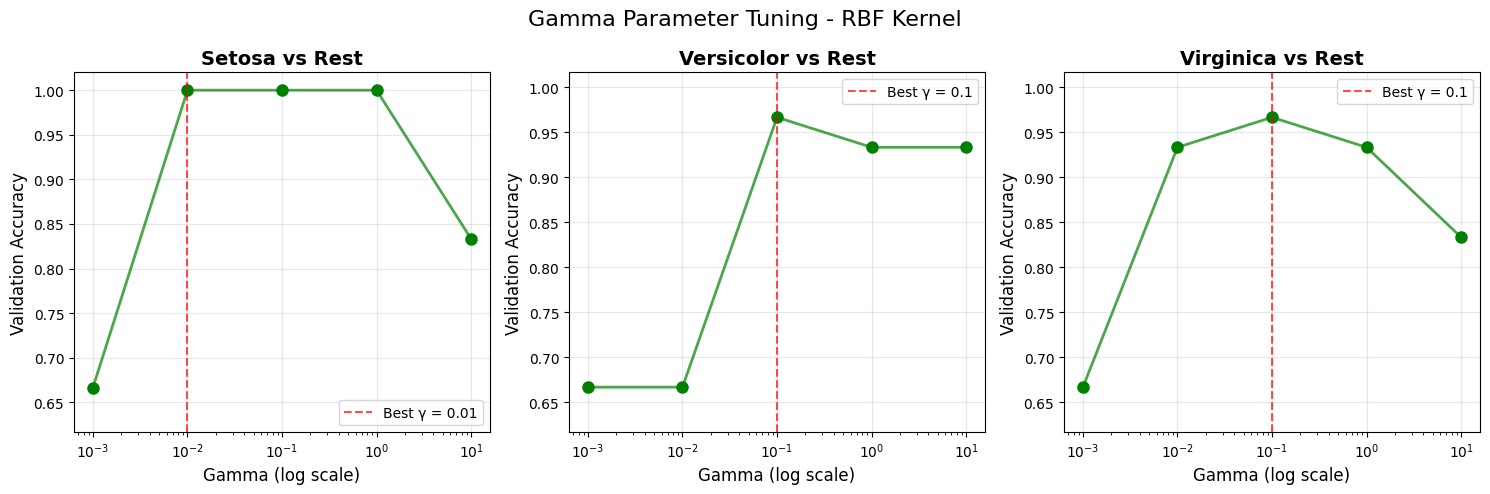

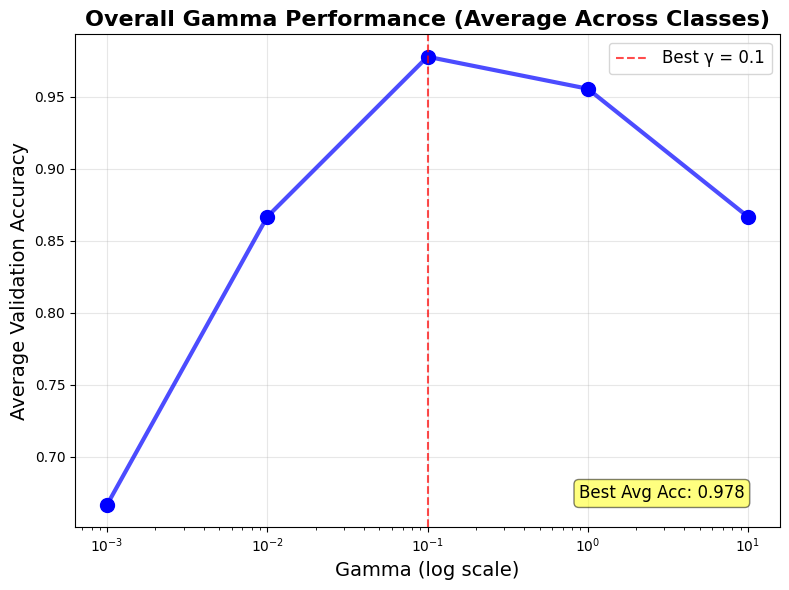


GAMMA TUNING SUMMARY

Per-class best gamma values:
       Class |   Best Gamma |  Val Accuracy
----------------------------------------
      setosa |        0.010 |         1.000
  versicolor |        0.100 |         0.967
   virginica |        0.100 |         0.967

Overall best gamma (based on average): 0.1
Average validation accuracy with best gamma: 0.978

SUPPORT VECTOR ANALYSIS

setosa:
     Gamma |      SVs |    Val Acc
-----------------------------------
     0.001 |       60 |      0.667
     0.010 |       32 |      1.000
     0.100 |       21 |      1.000
     1.000 |       38 |      1.000
    10.000 |       75 |      0.833

versicolor:
     Gamma |      SVs |    Val Acc
-----------------------------------
     0.001 |       61 |      0.667
     0.010 |       71 |      0.667
     0.100 |       52 |      0.967
     1.000 |       40 |      0.933
    10.000 |       81 |      0.933

virginica:
     Gamma |      SVs |    Val Acc
-----------------------------------
     0.001 |  

In [44]:
def tune_gamma_parameter(X_train, y_train, X_val, y_val, target_names,
                        gamma_candidates=None, C=1.0, SMO=None):
    """
    Find best gamma parameter for RBF kernel using validation set

    Parameters:
    -----------
    X_train, y_train : Training data
    X_val, y_val : Validation data
    target_names : list
        Names of target classes
    gamma_candidates : list
        Gamma values to test (default: [0.001, 0.01, 0.1, 1.0, 10.0])
    C : float
        Fixed C value to use during gamma tuning
    SMO : class
        SMO class for SVM training

    Returns:
    --------
    best_gamma : float
        Best gamma value found
    all_gamma_results : dict
        Results for each class with different gamma values
    """

    if gamma_candidates is None:
        # Default gamma values to test (logarithmic scale)
        gamma_candidates = [0.001, 0.01, 0.1, 1.0, 10.0]

    if SMO is None:
        raise ValueError("SMO class must be provided")

    print("\n" + "="*70)
    print("TUNING GAMMA PARAMETER FOR RBF KERNEL")
    print("="*70)
    print(f"Using fixed C = {C}")
    print(f"Testing gamma values: {gamma_candidates}")

    all_gamma_results = {}

    # Test gamma for each class
    for class_idx in range(3):
        class_name = target_names[class_idx]
        print(f"\n{'='*50}")
        print(f"Tuning gamma for {class_name} (class {class_idx}) vs rest")
        print(f"{'='*50}")

        # Binary labels
        y_train_binary = create_binary_labels(y_train, class_idx)
        y_val_binary = create_binary_labels(y_val, class_idx)

        print(f"\nClass distribution:")
        print(f"  Positive: {np.sum(y_train_binary == 1)} samples")
        print(f"  Negative: {np.sum(y_train_binary == -1)} samples")

        validation_results = []
        best_val_accuracy = -1
        best_gamma_for_class = None

        print(f"\nTesting different gamma values:")
        for gamma in gamma_candidates:
            print(f"  Testing gamma = {gamma:.3f}...", end=' ')
            start_time = time.time()

            # Train with current gamma
            svm = SMO(C=C, kernel_type='rbf', gamma=gamma, tol=1e-2, max_iter=500)

            try:
                svm.fit(X_train, y_train_binary)

                # Validate
                val_predictions = svm.predict(X_val)
                val_accuracy = np.mean(val_predictions == y_val_binary)

                elapsed = time.time() - start_time
                print(f"Accuracy: {val_accuracy:.3f}, Time: {elapsed:.1f}s, SVs: {len(svm.support_indices)}")

                validation_results.append({
                    'gamma': gamma,
                    'val_accuracy': val_accuracy,
                    'n_support_vectors': len(svm.support_indices),
                    'training_time': elapsed
                })

                if val_accuracy > best_val_accuracy:
                    best_val_accuracy = val_accuracy
                    best_gamma_for_class = gamma

            except Exception as e:
                print(f"Failed: {str(e)}")
                validation_results.append({
                    'gamma': gamma,
                    'val_accuracy': 0,
                    'n_support_vectors': 0,
                    'training_time': 0
                })

        all_gamma_results[class_name] = {
            'validation_results': validation_results,
            'best_gamma': best_gamma_for_class,
            'best_accuracy': best_val_accuracy
        }

        print(f"\nBest gamma for {class_name}: {best_gamma_for_class} (accuracy: {best_val_accuracy:.3f})")

    # Find overall best gamma (based on average performance across classes)
    gamma_avg_scores = {}
    for gamma in gamma_candidates:
        scores = []
        for class_name, results in all_gamma_results.items():
            for res in results['validation_results']:
                if res['gamma'] == gamma and res['val_accuracy'] > 0:
                    scores.append(res['val_accuracy'])
        if scores:
            gamma_avg_scores[gamma] = np.mean(scores)

    best_gamma = max(gamma_avg_scores.keys(), key=lambda k: gamma_avg_scores[k])

    # Plot gamma tuning results
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for idx, (class_name, results) in enumerate(all_gamma_results.items()):
        ax = axes[idx]

        # Get data
        gamma_values = [r['gamma'] for r in results['validation_results']]
        val_accuracies = [r['val_accuracy'] for r in results['validation_results']]

        # Remove failed runs
        valid_points = [(g, acc) for g, acc in zip(gamma_values, val_accuracies) if acc > 0]

        if valid_points:
            gamma_clean = [point[0] for point in valid_points]
            acc_clean = [point[1] for point in valid_points]

            # Sort for proper line plot
            sorted_pairs = sorted(zip(gamma_clean, acc_clean), key=lambda x: x[0])
            gamma_sorted = [pair[0] for pair in sorted_pairs]
            acc_sorted = [pair[1] for pair in sorted_pairs]

            # Plot
            ax.plot(gamma_sorted, acc_sorted, 'g-', linewidth=2, alpha=0.7)
            ax.plot(gamma_sorted, acc_sorted, 'go', markersize=8)
            ax.set_xscale('log')

        # Mark best gamma for this class
        if results['best_gamma'] is not None:
            ax.axvline(x=results['best_gamma'], color='red', linestyle='--', alpha=0.7,
                      label=f'Best γ = {results["best_gamma"]}')

        ax.set_xlabel('Gamma (log scale)', fontsize=12)
        ax.set_ylabel('Validation Accuracy', fontsize=12)
        ax.set_title(f'{class_name.capitalize()} vs Rest', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend()

        # Set y-axis limits
        if valid_points:
            min_acc = min(acc_clean)
            max_acc = max(acc_clean)
            y_margin = 0.05
            ax.set_ylim([max(0, min_acc - y_margin), min(1.02, max_acc + y_margin)])
        else:
            ax.set_ylim([0.8, 1.02])

    plt.suptitle('Gamma Parameter Tuning - RBF Kernel', fontsize=16)
    plt.tight_layout()
    plt.show()

    # Plot average performance across all classes
    plt.figure(figsize=(8, 6))

    gamma_list = sorted(gamma_avg_scores.keys())
    avg_scores = [gamma_avg_scores[g] for g in gamma_list]

    plt.plot(gamma_list, avg_scores, 'b-', linewidth=3, alpha=0.7)
    plt.plot(gamma_list, avg_scores, 'bo', markersize=10)
    plt.axvline(x=best_gamma, color='red', linestyle='--', alpha=0.7,
                label=f'Best γ = {best_gamma}')

    plt.xscale('log')
    plt.xlabel('Gamma (log scale)', fontsize=14)
    plt.ylabel('Average Validation Accuracy', fontsize=14)
    plt.title('Overall Gamma Performance (Average Across Classes)', fontsize=16, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)

    # Add text with best performance
    plt.text(0.95, 0.05, f'Best Avg Acc: {gamma_avg_scores[best_gamma]:.3f}',
             transform=plt.gca().transAxes, ha='right', va='bottom',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5),
             fontsize=12)

    plt.tight_layout()
    plt.show()

    # Summary
    print("\n" + "="*70)
    print("GAMMA TUNING SUMMARY")
    print("="*70)

    print(f"\nPer-class best gamma values:")
    print(f"{'Class':>12} | {'Best Gamma':>12} | {'Val Accuracy':>13}")
    print("-" * 40)

    for class_name, results in all_gamma_results.items():
        print(f"{class_name:>12} | {results['best_gamma']:>12.3f} | {results['best_accuracy']:>13.3f}")

    print(f"\nOverall best gamma (based on average): {best_gamma}")
    print(f"Average validation accuracy with best gamma: {gamma_avg_scores[best_gamma]:.3f}")

    # Show support vector counts for different gamma values
    print("\n" + "="*70)
    print("SUPPORT VECTOR ANALYSIS")
    print("="*70)

    for class_name, results in all_gamma_results.items():
        print(f"\n{class_name}:")
        print(f"{'Gamma':>10} | {'SVs':>8} | {'Val Acc':>10}")
        print("-" * 35)
        for res in results['validation_results']:
            if res['val_accuracy'] > 0:
                print(f"{res['gamma']:>10.3f} | {res['n_support_vectors']:>8} | {res['val_accuracy']:>10.3f}")

    return best_gamma, all_gamma_results


# First tune gamma for RBF kernel
best_gamma, gamma_results = tune_gamma_parameter(
    X_train, y_train, X_val, y_val, target_names,
    gamma_candidates=[0.001, 0.01, 0.1, 1.0, 10.0],
    C=1.0,  # Use a fixed C value for gamma tuning
    SMO=SMO
)

print(f"\n{'='*70}")
print(f"RECOMMENDED: Use gamma = {best_gamma} for RBF kernel training")
print(f"{'='*70}")


TRAINING BINARY SVMs WITH C TUNING (RBF kernel)
Using gamma = 0.1

Binary SVM: setosa (class 0) vs rest

Class distribution:
  Positive: 30 samples
  Negative: 60 samples

Tuning C parameter...
  Testing C = 0.10...     Converged in 19 iterations
Accuracy: 1.000, Time: 0.2s, SVs: 52
  Testing C = 0.50...     Converged in 11 iterations
Accuracy: 1.000, Time: 0.1s, SVs: 26
  Testing C = 1.00...     Converged in 7 iterations
Accuracy: 1.000, Time: 0.0s, SVs: 17
  Testing C = 5.00...     Converged in 3 iterations
Accuracy: 1.000, Time: 0.0s, SVs: 21
  Testing C = 10.00...     Converged in 5 iterations
Accuracy: 1.000, Time: 0.0s, SVs: 21

Best C = 0.1 (val acc: 1.000)

Training with best C...
    Converged in 17 iterations
Done in 0.2s

Results:
  Test Accuracy: 1.000
  Support Vectors: 51
  - Bound (α = C): 26
  - Non-bound (0 < α < C): 25

Binary SVM: versicolor (class 1) vs rest

Class distribution:
  Positive: 30 samples
  Negative: 60 samples

Tuning C parameter...
  Testing C = 0.10

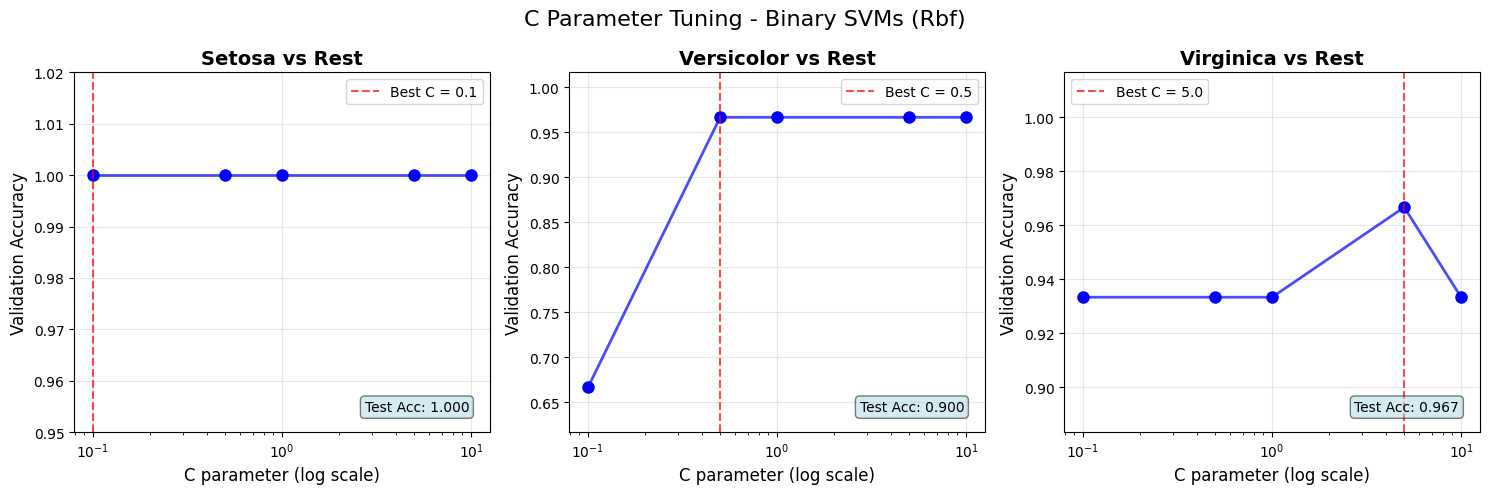


SUMMARY (RBF kernel)

Results:

       Class |   Best C |  Test Acc |             SVs
------------------------------------------------------------
      setosa |     0.10 |     1.000 |              51
  versicolor |     0.50 |     0.900 |              59
   virginica |     5.00 |     0.967 |              23


In [45]:
# RBF kernel training (after gamma tuning):
kernel = 'rbf'
rbf_results, rbf_svms = train_multiple_svms_with_kernel(
    X_train, y_train, X_val, y_val, X_test, y_test,
    target_names, kernel=kernel, gamma=best_gamma, SMO=SMO
)

###Summary of the hyperparameters selection:

**Best performing gamma per class (tested for a fixed C=1.0)**

```
       Class |   Best Gamma |  Val Accuracy
----------------------------------------
      setosa |        0.010 |         1.000
  versicolor |        0.100 |         0.967
   virginica |        0.100 |         0.967
```

**We will use a fixed value of gamma = 0.1**


**Best performing C parameter (tested for best gamma value):**
```

       Class |   Best C |  Test Acc |             SVs
------------------------------------------------------------
      setosa |     0.10 |     1.000 |              51
  versicolor |     0.50 |     0.900 |              59
   virginica |     5.00 |     0.967 |              23

```



**For the C values we will use the best C value for each class**



---

Already we see significantly better results for the per-class model

Especially a major improvment for the **versicolor** class - this is an expected outcome considering that both of the last classes never linearly seperable perfectly to use a linear kernel

#### **Now to analyze the multiclass model:**

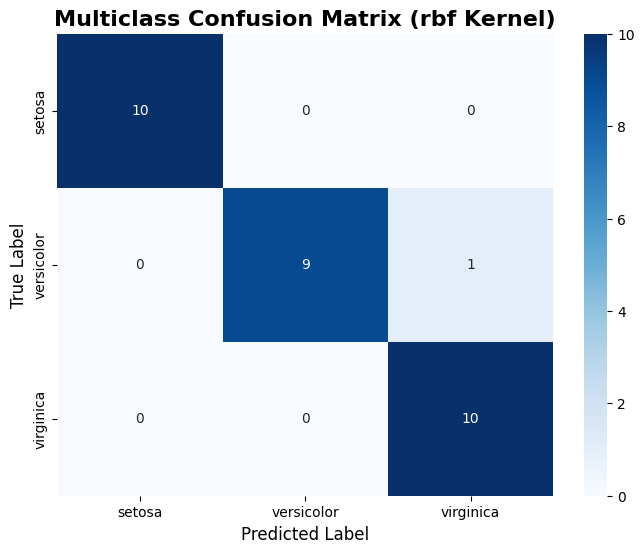


Overall Multiclass Accuracy (rbf kernel): 0.967

Per-class Performance:
       Class |  Precision |     Recall |   F1-Score
--------------------------------------------------
      setosa |      1.000 |      1.000 |      1.000
  versicolor |      1.000 |      0.900 |      0.947
   virginica |      0.909 |      1.000 |      0.952

Linear Accuracy: 0.733
RBF Accuracy: 0.967


In [46]:
rbf_evaluation = evaluate_multiclass_svm(
    X_test, y_test, rbf_svms, target_names, kernel_name='rbf'
)

print(f"\nLinear Accuracy: {linear_evaluation['overall_accuracy']:.3f}")
print(f"RBF Accuracy: {rbf_evaluation['overall_accuracy']:.3f}")



---

The above metric helps drive the point home - using the linear kernel we achieved (for the multiclass model) an accuracy of 67% while rbf is at 97%, marking a major improvment

#### **All metrics compiled below:**

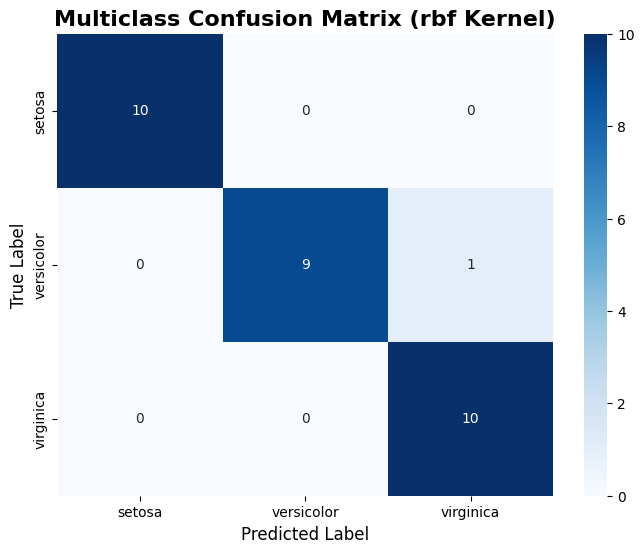


Overall Multiclass Accuracy (rbf kernel): 0.967

Per-class Performance:
       Class |  Precision |     Recall |   F1-Score
--------------------------------------------------
      setosa |      1.000 |      1.000 |      1.000
  versicolor |      1.000 |      0.900 |      0.947
   virginica |      0.909 |      1.000 |      0.952

Per-Class Performance (rbf kernel):
       Class |  Accuracy | Sensitivity | Specificity
------------------------------------------------------------
      setosa |     1.000 |       1.000 |       1.000
  versicolor |     0.967 |       0.900 |       1.000
   virginica |     0.967 |       1.000 |       0.950


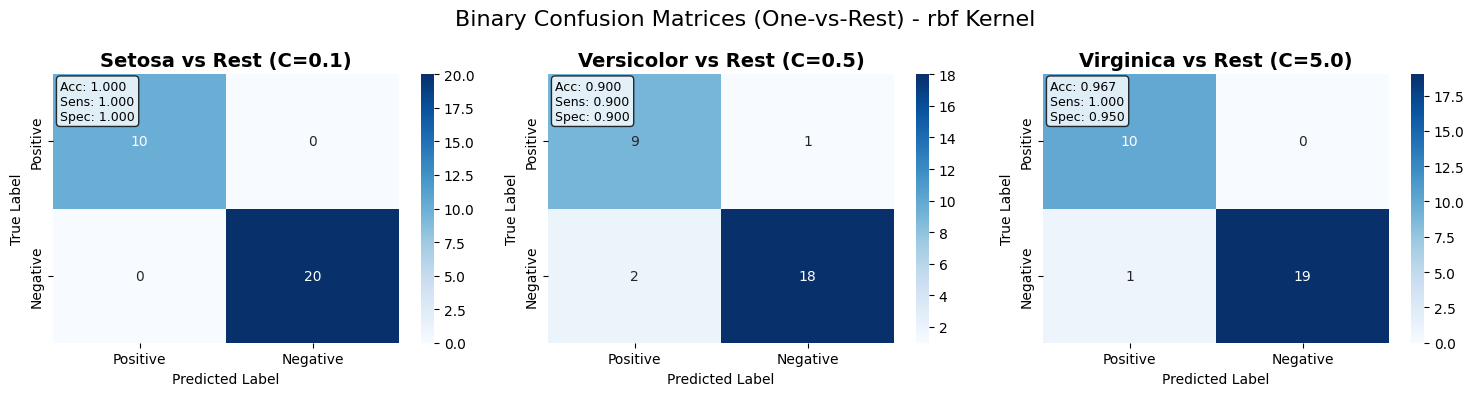

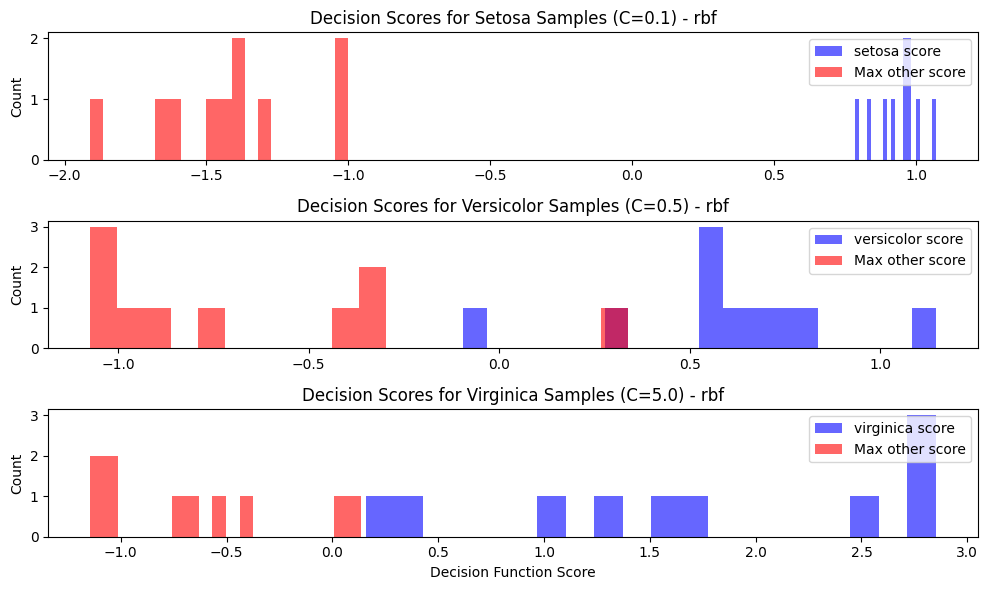


Linear Accuracy: 0.733
RBF Accuracy: 0.967


In [47]:
rbf_evaluation = evaluate_multiclass_svm(
    X_test, y_test, rbf_svms, target_names, kernel_name='rbf'
)
detailed_svm_analysis(
    X_test, y_test, rbf_svms, target_names, rbf_results, kernel_name='rbf'
)

print(f"\nLinear Accuracy: {linear_evaluation['overall_accuracy']:.3f}")
print(f"RBF Accuracy: {rbf_evaluation['overall_accuracy']:.3f}")

# **Kernel Comparasion Summary**

After running the SVM model with the SMO algorithm once with the linear kernel function and once with rbf kernel function we can conclude our main points all in relation to the scope of the unique problem of the data set:

**We started off by analyzing the scaterplot** and from there it was easy to see that for some classes in the one vs all method - a linear seperator simply couldnt be found to seperate (near-)perfectly and predict the data.

**Performing an analysis of the best performing C hyperparameter we derive the best C values to be used for each binary model**

**Running the SVM with the linear kernel we got the following outcome:**
*    Multiclass model accuracy = ~70%
*    Very poor performance for the most problematic class - versicolor, reaching a 67% accuracy in prediction in the binary model
*    **This means - the linear kernel performes poorly compared to the latter rbf kernel**

**Running the SVM with the rbf kernel:**
*     We started off by evaluating the hyperparameters C and gamma to use for the binary models, training them with these parameters.
*     Multiclass model accuracy = ~97% - a major improvment from the previous model
*     For the binary model - as expected the first (easeir) class performed still the best at a score of 1 yet all averaged at an accuracy of 97%

#### **Knowing we approach a not linearly seperable problem considering we are looking for a multiclass model - the best choice was obviously to not use a linear seperator, this analysis further proved the efficacy of tuning the kernel to the task**
